In [1]:
import os
os.chdir("..")  # vai para sales-etl-notebook
print("Current working dir:", os.getcwd())

Current working dir: /Users/thiagomoura/Documents/projetos/sales-etl-pyspark


In [2]:
!pip install python-dotenv

In [3]:
!pip install pyspark pandas python-dotenv pyyaml cryptography matplotlib seaborn

In [4]:
import sys
import os

# Caminho para raiz do projeto
sys.path.append(os.path.abspath(".."))

from src.config import load_config
from src.logger import setup_logger
from src.extract import extract_sales_csv
from src.transform import transform_sales
from src.load import load_sales_incremental
from src.generate_mock_data import generate_mock_sales_csv


In [5]:
from pyspark.sql import SparkSession

cfg = load_config()

spark = (
    SparkSession.builder
    .master(cfg["spark"]["master"])
    .appName("sales_etl_notebook")
    .config("spark.jars", "jars/postgresql-42.7.3.jar")
    .config("spark.sql.shuffle.partitions", cfg["spark"]["shuffle_partitions"])
    .getOrCreate()
)


26/02/10 10:51:52 WARN Utils: Your hostname, Thiagos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.11 instead (on interface en0)
26/02/10 10:51:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/02/10 10:51:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
logger = setup_logger()
logger.info("Notebook ETL started")

2026-02-10 10:51:57,398 | INFO | Notebook ETL started


In [7]:
generate_mock_sales_csv("../data/raw/sales.csv", n_rows=10)

Mock CSV generated: ../data/raw/sales.csv (10 rows)


In [8]:
raw_df = extract_sales_csv(spark, "../data/raw/sales.csv")
raw_df.show(5)

+--------------+-----------+----------+--------+--------------------+
|transaction_id|customer_id|product_id|quantity|           timestamp|
+--------------+-----------+----------+--------+--------------------+
|             1|       2940|       230|       1|2026-02-08 01:56:...|
|             2|       4570|       190|       2|2026-02-09 12:05:...|
|             3|       1175|       126|       4|2026-02-01 04:41:...|
|             4|       2533|        41|       6|2026-02-09 04:16:...|
|             5|       2601|       154|      10|2026-02-05 14:42:...|
+--------------+-----------+----------+--------+--------------------+
only showing top 5 rows



In [9]:
transformed_df = transform_sales(raw_df, cfg)
transformed_df.show(5)

+--------------+-----------+----------+--------+----------+
|transaction_id|customer_id|product_id|quantity| sale_date|
+--------------+-----------+----------+--------+----------+
|             1|       2940|       230|       1|2026-02-08|
|             2|       4570|       190|       2|2026-02-09|
|             3|       1175|       126|       4|2026-02-01|
|             4|       2533|        41|       6|2026-02-09|
|             5|       2601|       154|      10|2026-02-05|
+--------------+-----------+----------+--------+----------+
only showing top 5 rows



In [10]:
existing_ids = (
    spark.read.jdbc(
        url=cfg["db"]["url"],
        table="sales",
        properties={
            "user": cfg["db"]["user"],
            "password": cfg["db"]["password"],
            "driver": cfg["db"]["driver"]
        }
    )
    .select("transaction_id")
)

existing_ids.show()

+--------------+
|transaction_id|
+--------------+
|             1|
|             2|
|             3|
|             4|
|             5|
|             6|
|             7|
|             8|
|             9|
|            10|
|            11|
|            12|
|            13|
|            14|
|            15|
|            16|
|            17|
|            18|
|            19|
|            20|
+--------------+
only showing top 20 rows



In [11]:
df_to_insert = transformed_df.join(existing_ids, on="transaction_id", how="left_anti")

In [12]:
df_to_insert.write.jdbc(
    url=cfg["db"]["url"],
    table="sales",
    mode="append",
    properties={
        "user": cfg["db"]["user"],
        "password": cfg["db"]["password"],
        "driver": cfg["db"]["driver"]
    }
)

In [13]:
from pyspark.sql import functions as F

# Vendas por dia
transformed_df.groupBy("sale_date").agg(F.sum("quantity").alias("total_quantity")).orderBy("sale_date").show()

# Top 10 produtos
transformed_df.groupBy("product_id").agg(F.sum("quantity").alias("total_quantity")).orderBy(F.desc("total_quantity")).show()


+----------+--------------+
| sale_date|total_quantity|
+----------+--------------+
|2026-02-01|            14|
|2026-02-04|             2|
|2026-02-05|            10|
|2026-02-07|            16|
|2026-02-08|             1|
|2026-02-09|            15|
+----------+--------------+

+----------+--------------+
|product_id|total_quantity|
+----------+--------------+
|       154|            10|
|       129|            10|
|       238|             8|
|       262|             8|
|       146|             7|
|        41|             6|
|       126|             4|
|       190|             2|
|       257|             2|
|       230|             1|
+----------+--------------+



In [15]:
props = {"user": cfg["db"]["user"], "password": cfg["db"]["password"], "driver": cfg["db"]["driver"]}
df_db = spark.read.jdbc(url=cfg["db"]["url"], table=cfg["db"]["table"], properties=props)
df_db.show(10)

+--------------+--------------------+--------------------+--------+----------+
|transaction_id|         customer_id|          product_id|quantity| sale_date|
+--------------+--------------------+--------------------+--------+----------+
|         41696|75ab3e0a8f99144f9...|a68b412c4282555f1...|       4|2026-01-28|
|           932|96382608813353bee...|44cb730c420480a04...|       6|2026-02-02|
|          1592|15b9e0db83ca5103d...|768b84ef05f655d57...|       9|2026-02-03|
|         36766|66dfd8bb9bcf776b9...|37c20f19f3272b5cc...|       5|2026-02-02|
|         43572|5119e090c80757fec...|b4bbe448fde336bb6...|      10|2026-02-05|
|         23130|25e16cbd45433fc68...|27d719c754aacd492...|       6|2026-02-03|
|         15167|cca40327e9be88bde...|3e1e967e9b793e908...|       3|2026-02-05|
|         40800|0d46ebf59e025c235...|43974ed74066b207c...|       6|2026-02-04|
|         16307|8c6c42f379f08f03b...|c0509a487a18b003b...|       2|2026-02-02|
|         23157|82887006d04d939ff...|29db0c6782dbd50

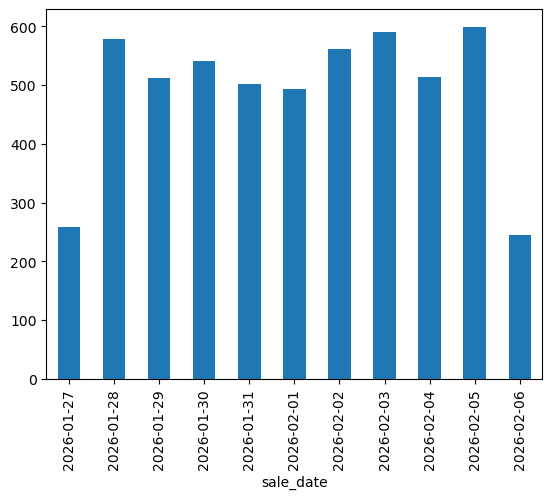

In [16]:
pdf = df_db.limit(1000).toPandas()
import matplotlib.pyplot as plt
pdf.groupby("sale_date")["quantity"].sum().plot(kind="bar")
plt.show()